# Sklearn: Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. Clustering metrics
Despite being an unsupervised task, clustering has their own [evaluation metrics]. They should be used with a grain of salt.

[evaluation metrics]: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

### 1.1. Metrics
The following notations are used for all metrics:
- $\mathbf{s}_n$ (for $n=1,2,\dots,N$) is a data point
- $\mathcal{C}_k$ (for $k=1,2,\dots,K$) is a cluster, it has the size of $|\mathcal{C}_k|$ and the centroid $\mathbf{c}_k$

#### Silhouette coefficient
[Silhouette coefficient] of a clustering model is measured as the average Silhouette value over all data points:

$$\mathrm{SC}=\frac{1}{N}\sum_{n=1}^{N}{\frac{a_n-b_n}{max\{a_n,b_n\}}}$$

Let's say the observation $\mathbf{s}_n$ belongs to the cluster $A$ and the nearest cluster of $A$ is $B$ (measured by the distance between centroids). The formulas for $a_n$ and $b_n$ are:
- $\displaystyle{a_n=\frac{1}{|A|-1}}\sum_{\mathbf{s}_i\in A}{d(\mathbf{s}_n,\mathbf{s}_i)}$ is the average distance between $\mathbf{s}_n$ and all other data points in the cluster $A$.
- $\displaystyle{b_n=\frac{1}{|B|}\sum_{\mathbf{s}_i\in B}{d(\mathbf{s}_n,\mathbf{s}_i)}}$ is the average distance between $\mathbf{s}_i$ and all data points in the cluster $B$.

The calculation of Silhouette coefficient ensures its value to be in range $[-1,1]$. A Silhouette coefficient close to $1$ indicates the data was appropriately clustered.

[Silhouette coefficient]: https://en.wikipedia.org/wiki/Silhouette_(clustering)

#### Calinski-Harabasz Index
Calinski-Harabasz Index is calculated using the following formula:

$$\mathrm{CHI}=\frac{\text{SSB}}{\text{SSW}}\cdot\frac{N-K}{K-1}$$

where:
- $\displaystyle{\text{SSB}=\sum_{k=1}^K K\,\|\mathbf{c}_k-\bar{\mathbf{s}}\|_2^2}$ is the overall between-cluster variance
- $\displaystyle{\text{SSW}=\sum_{k=1}^{K}\sum_{\mathbf{s}_i\in C_k}\|\mathbf{s}_i-\mathbf{c}_k\|_2^2}$ is the overall within-cluster variance
- $\bar{\mathbf{s}}$ is the mean of all observations and $\|\cdot\|_2$ denotes L2 norm of a vector

#### Davies-Bouldin Index
The calculation of Davies-Bouldin Index follows these steps:

- Step 1: For each cluster $\mathcal{C}_k$, calculate the goodness score $D_k$.
    - Compute the measure of scatter $s_k$ for cluster $\mathcal{C}_k$ by taking the average Euclidean distance from each point of $\mathcal{C}_k$ to the centroid $\mathbf{c}_k$. A small $s_k$ means data points in $\mathcal{C}_k$ are close to the centroid.
    - For every cluster $\mathcal{C}_i$ other than $\mathcal{C}_k$, compute the Euclidean distance $d_{ki}$ between the centroids $\mathbf{c}_k$ and $\mathbf{c}_i$. A great $d_{ki}$ means the two clusters are well separated.
    - Construct $\displaystyle{R_{ki}=\frac{s_k+s_i}{d_{ki}}}$ which measures the goodness of the clustering model. $R_{ki}$ should be as small as possible.
    - Select $\displaystyle{D_k=\max_{i}{R_{ki}}}$ being the worst case of $R_{ki}$.
- Step 2: Calculate the Davies-Bouldin Index:

$$\mathrm{DBI}=\frac{1}{K}\sum_{k=1}^{K}{D_k}$$

### 1.2. Implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

In [2]:
dfIris = pd.read_csv('../data/iris.csv')

x = dfIris.drop(columns='species')
cluster = dfIris['species']

In [3]:
silhouette_score(x, cluster)

0.5034774406932966

In [4]:
davies_bouldin_score(x, cluster)

0.7513707094756737

In [5]:
calinski_harabasz_score(x, cluster)

487.33087637489984

## 2. K-Means

### 2.1. Algorithm
Given a dataset having $N$ observations $(\mathbf{s}_1,\mathbf{s}_2,\dots,\mathbf{s}_n)$, the [K-Means] algorithm is described in the following steps:
- Step 1: Initialize the centroid for $K$ clusters by randomly selecting $K$ points from the dataset.
- Step 2: Assign data points to the nearest centroid, using Euclidean distance. This is also known as the Expectation step.
- Step 3: Update new centroids to be the mean of the clusters. This is also known as the Maximization step.
- Step 4: Repeat step 2 and 3 until a stopping condition is met. Available stopping criteria are (1) the maximum of iterations and (2) the coverage tolerance value.

[K-Means]: https://en.wikipedia.org/wiki/K-means_clustering

### 2.2. Implementation
Scikit-learn implements K-Means via the [`KMeans`] class, it has the following hyperparameters:

- `n_clusters`: the number of clusters ($K$), defaults to *8*.
- `n_init`: the number of time initializing different centroids, defaults to *10*.
- `max_iter`: the maximum number of iterations for a single run, defaults to *300*.

[`KMeans`]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
df = pd.read_csv('../data/mall_customers.csv')
df.head()

customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

In [3]:
x = df[['annual_income','spending_score']]

In [4]:
km = KMeans(n_clusters=5)
cluster = km.fit_predict(x)
result = x.assign(cluster=cluster)
result.head()

annual_income  spending_score  cluster
0             15              39        4
1             15              81        1
2             16               6        4
3             16              77        1
4             17              40        4

In [5]:
silhouette_score(x, cluster)

0.553931997444648

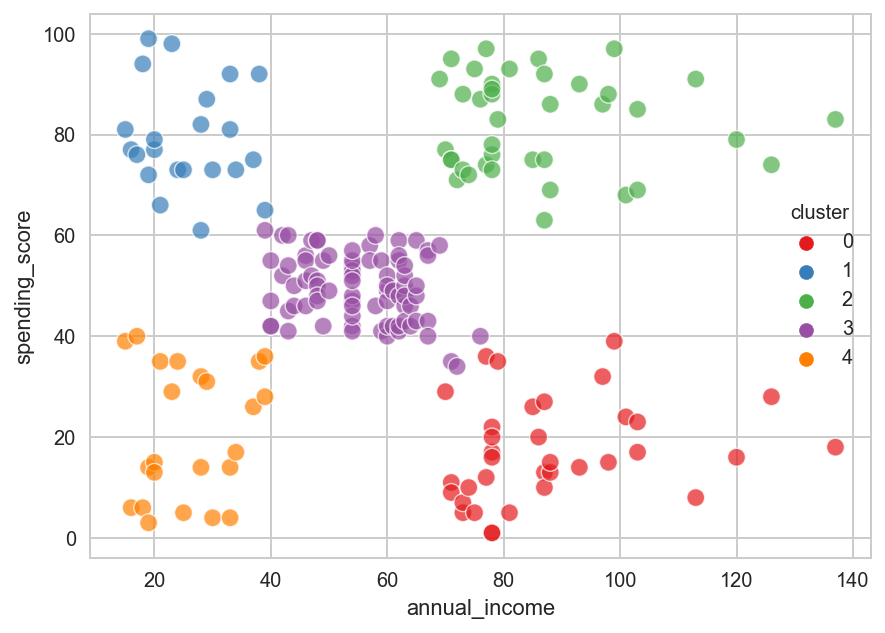

In [6]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='cluster', palette='Set1', alpha=.7, s=80)
plt.show()

#### Determining K
The Elbow method (which is actually grid search) plots the model evaluation score against different values of $K$. However, some evaluation metrics are monotonic functions with respect to $K$, and this leads to a situation that each cluster contains a single point only. When facing such a bad case, $K$ should be chosen at the point that model score no longer changes dramatically.

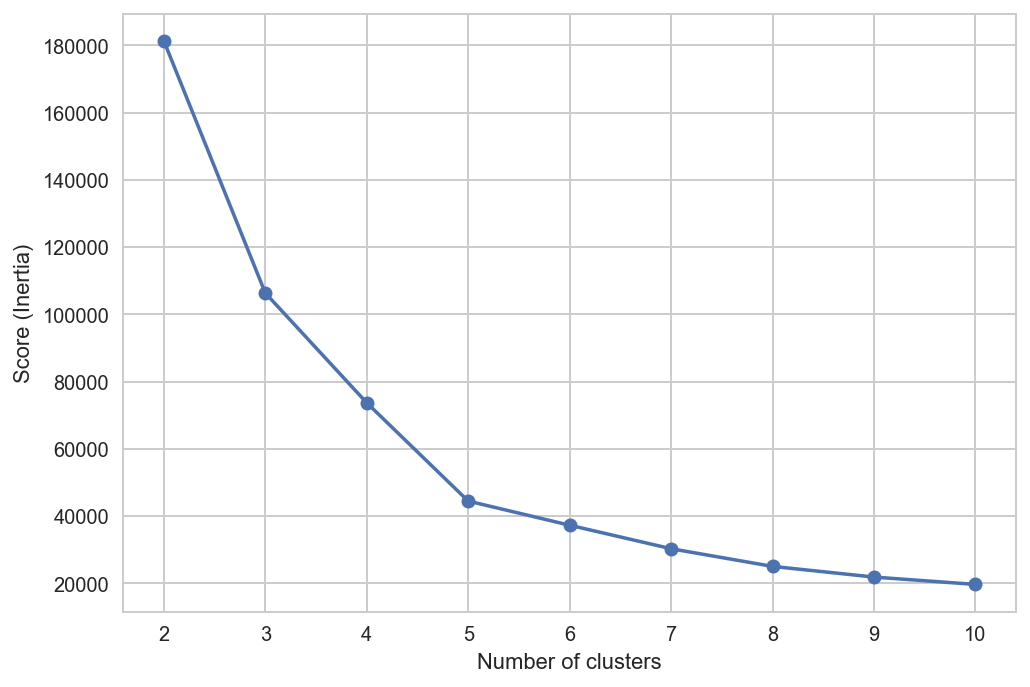

In [7]:
ks = range(2, 11)
scores = [KMeans(n_clusters=k).fit(x).inertia_ for k in ks]

plt.plot(ks, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score (Inertia)')
plt.show()

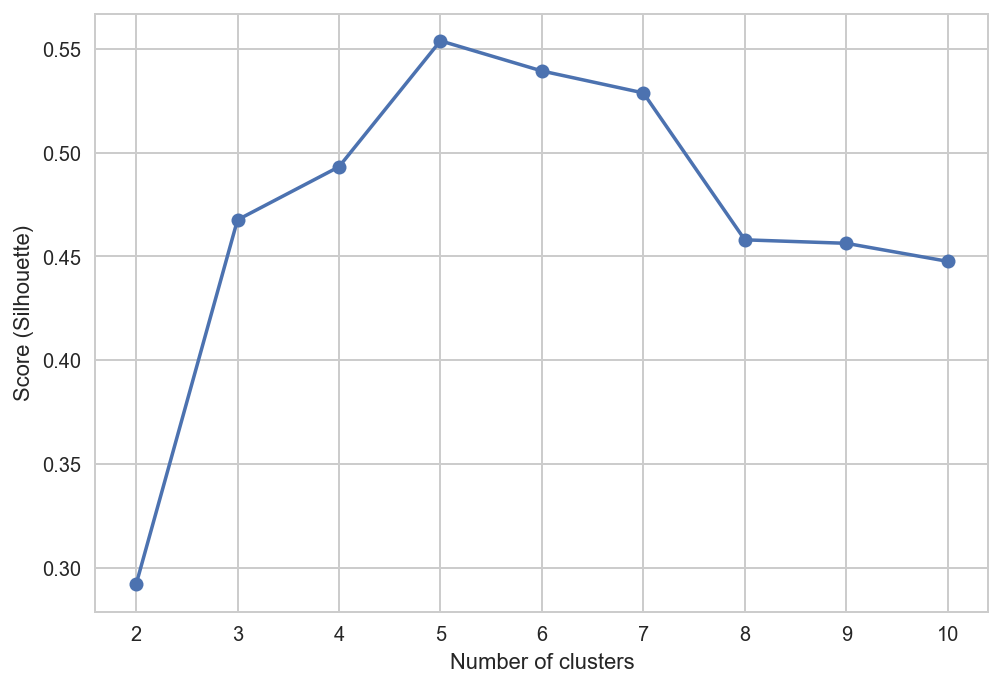

In [13]:
ks = range(2, 11)
scores = []
for k in ks:
    km = KMeans(n_clusters=k)
    cluster = km.fit_predict(x)
    score = silhouette_score(x, cluster)
    scores.append(score)

plt.plot(ks, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score (Silhouette)')
plt.show()

## 3. Mean Shift

### 3.1. Algorithm
[Mean Shift] is a non-parametric, density-based algorithm which uses the concept of Kernel Density Estimation mentioned in the topic *Seaborn: Data Visualization*. The main idea of Mean Shift is to place a Gaussian kernel (a special case of RBF function) on each data point and then add them up. This process results in *local maxima*, each represents a high density area and hence becomes a cluster centroid. The kernel function used in Mean Shift has the following equation:

$$K(x) = \frac{1}{h\sqrt{2\pi}}\cdot\exp{\left(-\frac{\parallel x-x_n\parallel_2^2}{h^2}\right)}$$

Mean Shift does not require users to select the number of clusters, however, the value of bandwidth $h$ needs to be set appropriately. A very small bandwidth represents peaked kernel curve and tends to make each data point a cluster its own, while a very large bandwidth results in a single cluster containing all data points.

[Mean Shift]: https://en.wikipedia.org/wiki/Mean_shift

#### Iterative method
The algorithm to find *local maxima* of the KDE is called *mean-shift iteration*, which runs on some random points inside the *convex hull* of the dataset. The final goal of this method is to shift those random points to highest density regions. For each point $\mathbf{s}$, implement the following steps:
- Step 1. Create a circular sliding window centered at the point $\mathbf{s}$ with the radius $h$.
- Step 2. At each iteration, shift the circle centre to the mean of all data points within the circle. This gradually shifts the centres towards the high density regions.
- Step 3. Repeat steps 1 and 2 until the centre no longer moves.

Here is an illustration of how Mean Shift works:

:::{image} ../image/mean_shift.gif
:height: 300px
:align: center
:::

### 3.2. Implementation
Scikit-learn implements Mean Shift via the [`MeanShift`] class, it has the following hyperparameters:
- `bandwidth`: bandwidth used in RBF, defaults to *None* (is estimated by Scikit-learn).
- `max_iter`: the maximum number of iterations for a single run, defaults to *300*.

[`MeanShift`]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [16]:
df = pd.read_csv('../data/mall_customers.csv')
df.head()

customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

In [17]:
x = df[['annual_income','spending_score']]

In [18]:
ms = MeanShift(bandwidth=25)
cluster = ms.fit_predict(x)
result = x.assign(cluster=cluster)
result.head()

annual_income  spending_score  cluster
0             15              39        4
1             15              81        3
2             16               6        4
3             16              77        3
4             17              40        4

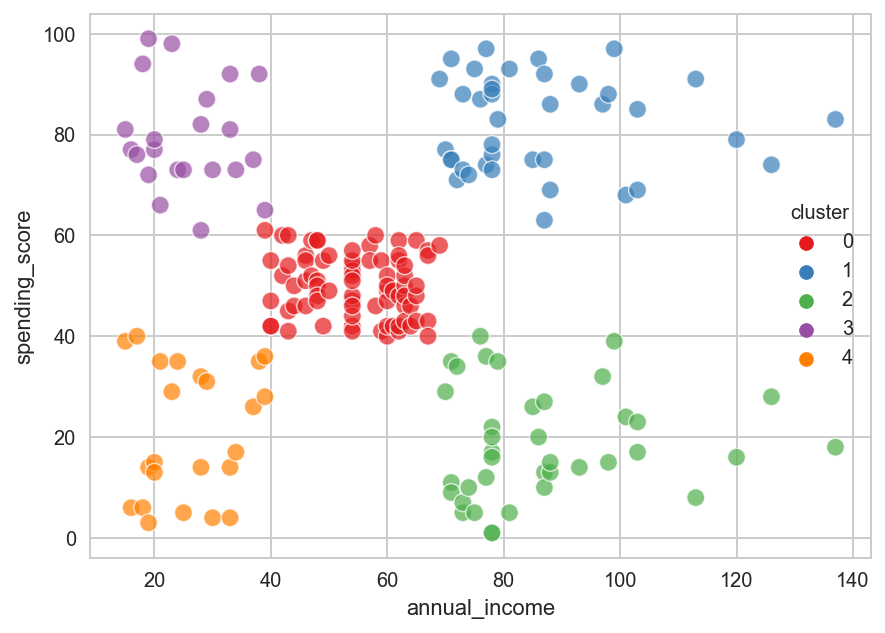

In [19]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='cluster', palette='Set1', alpha=.7, s=80)
plt.show()

#### Estimating bandwidth
Scikit-Learn provides the `estimate_bandwith()` function returning the best bandwidth for the dataset. Given $n$ data points $\mathbf{s}_1,\mathbf{s}_2,\dots,\mathbf{s}_n$ and a pre-defined `quantile` value $q$, $q\in(0,1]$. The bandwidth $h$ is estimated by taking the average distance between each point and its furthest neighbor among $\lfloor nq\rfloor$ nearest neighbors.

This estimation method allows users to put less effort into hyperparameter tuning, since the quantile value is usually $q\in(0.1, 0.3)$. However, finding nearest neighbors for every data point is computationally expensive, therefore, this method does not scale very well. When the dataset is large, the function parameter `n_samples` should be set in order to downsample data.

In [20]:
estimate_bandwidth(x, quantile=0.17)

24.342868108278907

## 4. Hierarchical Clustering
[Hiereachical Clustering] refers to a family of nested clustering algorithms, which is used as either an unsupervised Machine Learning algorithm or a cluster analysis method. There are typically two strategies:
- Divisive Clustering, which uses a *top-down* approach.
- Agglomerative Clustering, which uses a *bottom-up* approach. Used in Scikit-learn.

[Hiereachical Clustering]: https://en.wikipedia.org/wiki/Hierarchical_clustering

### 4.1. Algorithm
Scikit-learn use [Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) to construct nested clusters. In this algorithm, each observation starts in its own cluster and at each iteration, the closest pair of clusters is merged together. Until there is a single cluster containing all data points left, the algorithm stops.

To decide the closest pair of clusters, the distances between each pair are arranged in a matrix. There are a couple of strategies to define the distance between two clusters, commonly called *linkage* criteria.
- [Single lingake]: it uses the closest pair of observations between the two clusters. This approach works well when clusters are far enough from each other and cannot separate properly if there are noises between clusters.
- [Complete lingake]: it uses the furthest pair of observations between the two clusters. Being exactly opposite to single linkage, complete linkage does pretty well when there are noises but tends to break large clusters.
- [Average linkage]: it uses the average distance of all observation pairs.
- [Ward linkage]: it minimizes the variance of the clusters being merged. This method has the most stable performance one overall and hence becomes the default linkage used in Scikit-Learn.

[Single lingake]: https://en.wikipedia.org/wiki/Single-linkage_clustering
[Complete lingake]: https://en.wikipedia.org/wiki/Complete-linkage_clustering
[Average linkage]: https://en.wikipedia.org/wiki/UPGMA
[Ward linkage]: https://en.wikipedia.org/wiki/Ward%27s_method

### 4.2. Implementation
Scikit-learn implements Hierarchical Clustering via the class [`AgglomerativeClustering`], with the following hyperparameters:
- `n_clusters`: the number of clusters to find, defaults to *2*.
- `linkage`: the linkage criterion to use, defaults to *ward*. Other options are *single*, *average*, *complete*.
- `affinity`: the distance metric to compute the linkage, defaults to *euclidean*. Other options are *l1*, *l2*, *manhattan* and *cosine*.

[`AgglomerativeClustering`]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [22]:
df = pd.read_csv('../data/mall_customers.csv')
df.head()

customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

In [23]:
x = df[['annual_income','spending_score']]

In [24]:
ac = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster = ac.fit_predict(x)
result = x.assign(cluster=cluster)
result.head()

annual_income  spending_score  cluster
0             15              39        4
1             15              81        3
2             16               6        4
3             16              77        3
4             17              40        4

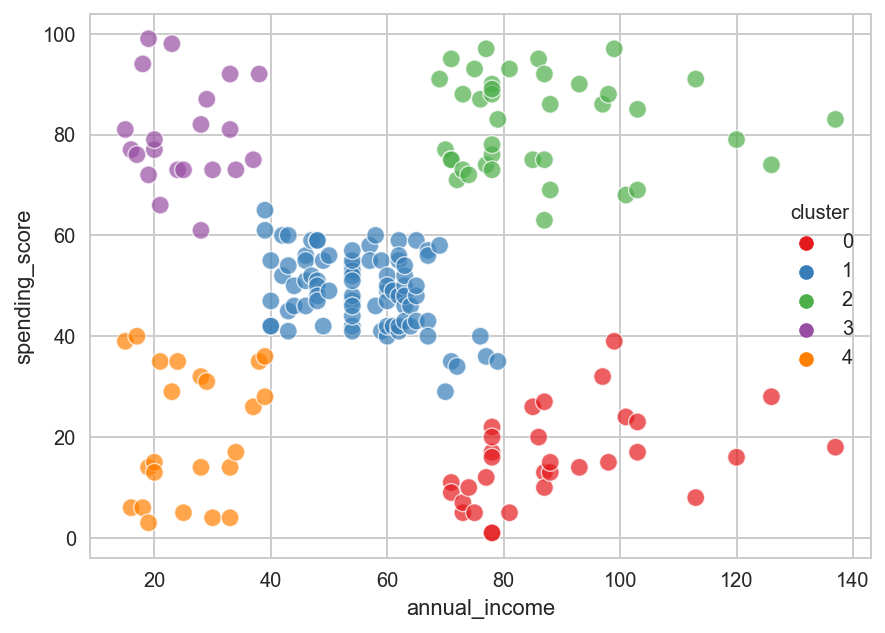

In [25]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='cluster', palette='Set1', alpha=.7, s=80)
plt.show()

#### Interpretation
[Dendrogram](https://en.wikipedia.org/wiki/Dendrogram) is a tree-like diagram visualizing multi-level relationship and thus can be used in Hierarchical Clustering visualization.

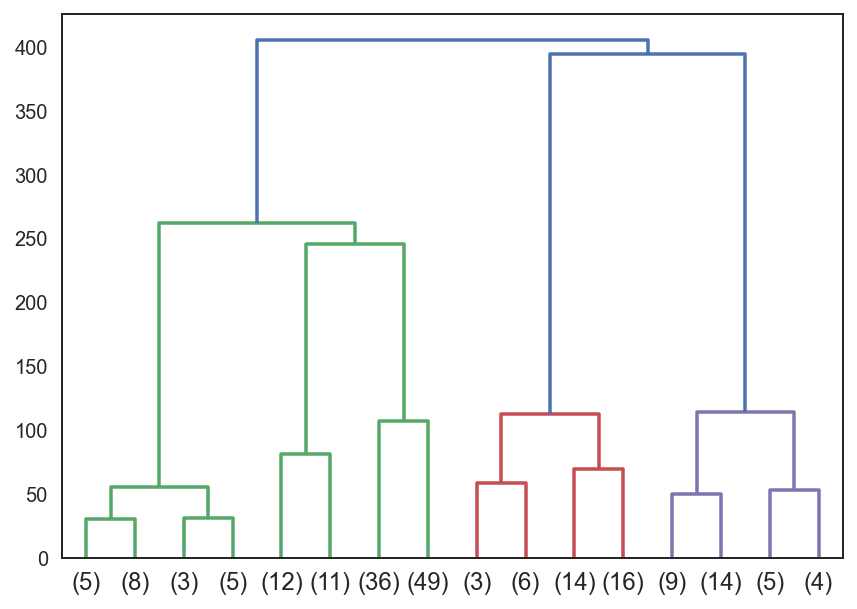

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set_style('white')

plot_data = linkage(x, method='ward')

plt.figure(figsize=(7, 5))
dendrogram(plot_data, p=3, truncate_mode='level')
plt.show()

## 5. DBSCAN

### 5.1. Algorithm
[DBSCAN], (Density-Based Spatial Clustering of Applications with Noises), is an interesting clustering algorithm which has the ability to detect anomalies and to handle non-convex clusters. With a pre-selected value of max distance ($\epsilon$) and min instances, the algorithm classifies data points into three categories:
- Core point: a point having enough neighbors within a given radius.
- Edge point: a point not qualifying as a core, but being a neighbor of another core point.
- Outlier: neither being a core nor an edge point.

DBSCAN is described in the following process:
- Step 1: Begins with a non-visited, random point. If there are at least a number of points around it within the radius $\epsilon$, this point is marked as a core point and forms a cluster with its neighbors. Otherwise, it is clustered as an outlier.
- Step 2: Determine whether each neighbor of the previous point is a core point or an edge point. If it is another core point, repeat step 1 and keep extending the current cluster.
- Step 3: Repeat step 1 and 2 until all members of the current cluster have been revealed. Finish the cluster.
- Step 4: Randomize a new non-visited point, repeat step 1, 2 and 3 until all data points have been visited. At the end, each point may either belong to a cluster or be an outlier.

:::{image} ../image/dbscan.gif
:height: 300px
:align: center
:::

[DBSCAN]: https://en.wikipedia.org/wiki/DBSCAN

### 5.2. Implementation
The class [`DBSCAN`] has the following hyperparameters:
- `eps`: the radius of the neighborhood circle ($\epsilon$), defaults to *0.5*.
- `min_samples`: the minimum number of neighbors a sample must have to be treated as a core point, defaults to *5*.

[`DBSCAN`]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [28]:
df = pd.read_csv('../data/mall_customers.csv')
df.head()

customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

In [29]:
x = df[['annual_income','spending_score']]

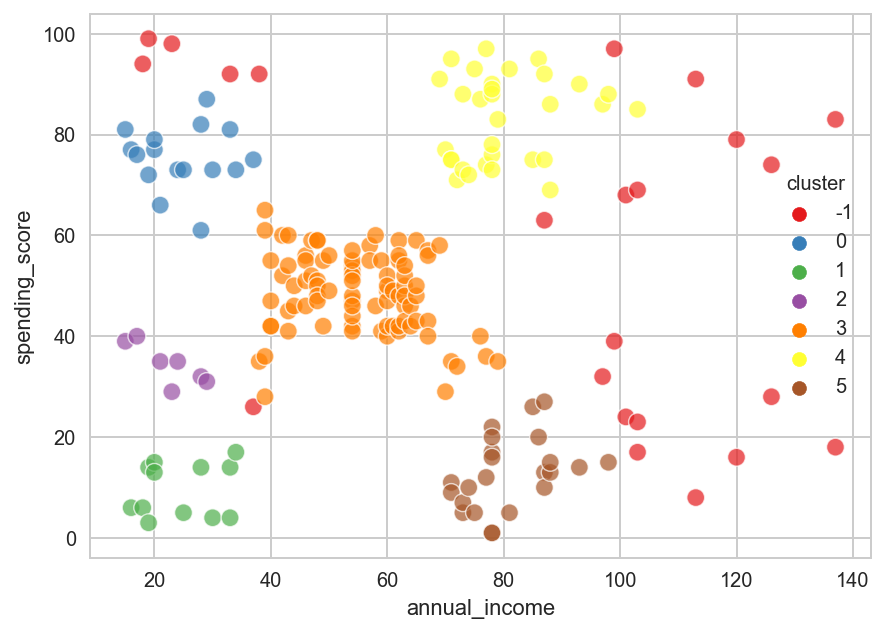

In [30]:
dbscan = DBSCAN(eps=9, min_samples=5)
cluster = dbscan.fit_predict(x)
result = x.assign(cluster=cluster)
# result.head()

plt.figure(figsize=(7,5))
sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='cluster', palette='Set1', alpha=.7, s=80)
plt.show()

## 6. Gaussian Mixture Models

### 6.1. Algorithm
[Gaussian Mixture Models] (GMM) is another algorithm that uses the concept of [Expectation-Maximization] besides K-Means. GMM is way more flexible than K-Means since it uses [ellipses] to define clusters instead of circles. Another advantage of GMM is the ability of predicting probability of an observation belongs to a cluster using [multivariate Gaussian distribution] $\mathbf{X}=(\mathbf{s}_1,\mathbf{s}_2,\dots,\mathbf{s}_N)\sim\mbox{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ with the following probability density function:

$$f(\mathbf{x};\boldsymbol{\mu},\boldsymbol{\Sigma}) =
\frac{1}{\sqrt{(2\pi)^k|\boldsymbol{\Sigma}|}}
\cdot
\exp{\left(-\frac{1}{2}\frac{(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}}(\mathbf{x}-\boldsymbol{\mu})}{\boldsymbol{\Sigma}}\right)}$$

[Gaussian Mixture Models]: https://scikit-learn.org/stable/modules/mixture.html#gmm
[Expectation-Maximization]: https://en.wikipedia.org/wiki/Expectationâ€“maximization_algorithm
[ellipses]: https://en.wikipedia.org/wiki/Ellipsis
[multivariate Gaussian distribution]: https://en.wikipedia.org/wiki/Multivariate_normal_distribution

For simplification purposes, this section describes how the algorithm works on a univariate dataset. Given $N$ observations $s_1,s_2,\dots,s_N$ and a pre-selected number of clusters, $K$.


*Step 1: Initialization*

- Select at random $K$ points from the dataset without replacement to be the means $\mu_1,\mu_2,\dots,\mu_K$ of $K$ clusters.

- Set all cluster variances to the sample variance: $\displaystyle{\sigma_1^2=\sigma_2^2=\dots=\sigma_K^2=\frac{1}{N}\sum_{n=1}^{N}{(s_n-\bar{s})^2}}$.

- Set all cluster weights equally: $\displaystyle{w_1=w_2=\dots=w_k=\frac{1}{K}}$. Notice that cluster weights should always sum up to 1.


*Step 2 - Expectation*

- Calculate $\displaystyle{L_{nk}=\mathrm{N}(s_n\mid\mu_k,\sigma_k)}$, the likelihood that the observation $s_n$ belongs the cluster $\mathcal{C}_k$.

- Calculate $\displaystyle{p_{nk}=\frac{w_kL_{nk}}{w_1L_{n1}+w_2L_{n2}+\dots+w_kL_{nk}}}$, the probability that the observation $s_n$ belongs to the cluster $\mathcal{C}_k$.


*Step 3 - Maximization*
- Update new weight $\displaystyle{w_k=\frac{1}{N}\sum_{n=1}^{N}{p_{nk}}}$ for cluster $\mathcal{C}_k$.

- Update new mean $\displaystyle{\mu_k=\frac{p_{1k}s_1+p_{2k}s_2+\dots+p_{nk}s_n}{p_{1k}+p_{2k}+\dots+p_{nk}}}$ for cluster $\mathcal{C}_k$.

- Update new variance $\displaystyle{\sigma_k^2=\frac{p_{1k}(s_1-\mu_k)^2+p_{2k}(s_2-\mu_k)^2+\dots+p_{nk}(s_n-\mu_k)^2}{p_{1k}+p_{2k}+\dots+p_{nk}}}$ for cluster $\mathcal{C}_k$.

Finally, the expectation step and the maximization step are repeated until converged.

### 6.2. Implementation
The class [`GaussianMixture`] has the following hyperparameters:
- `n_components`: the number of clusters, defaults to *1*.
- `max_iter`: the maximum number of EM iterations to perform, defaults to *100*.

[`GaussianMixture`]: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-deep', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [32]:
df = pd.read_csv('../data/mall_customers.csv')
df.head()

customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

In [33]:
x = df[['annual_income','spending_score']]

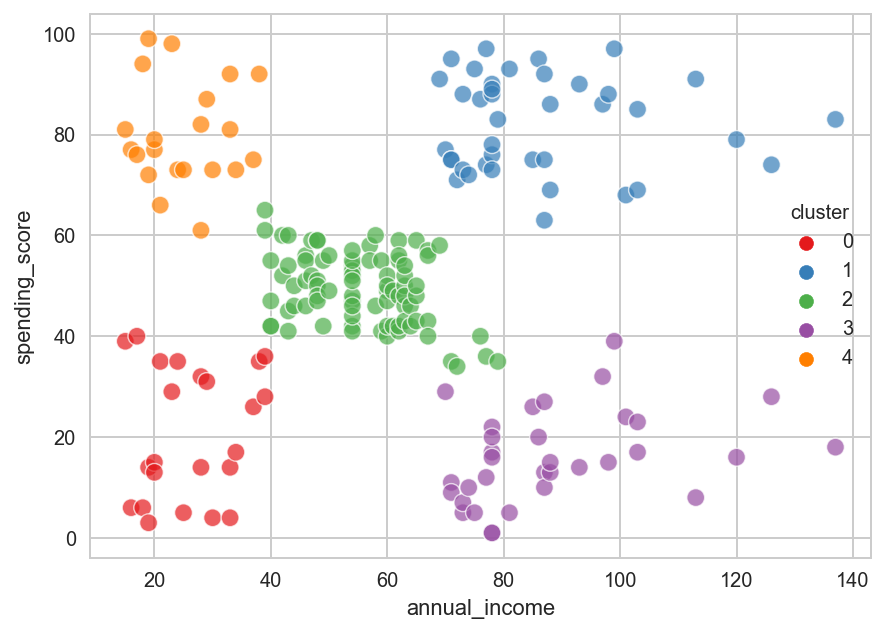

In [34]:
gmm = GaussianMixture(n_components=5)
cluster = gmm.fit_predict(x)
result = x.assign(cluster=cluster)
# result.head()

plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='cluster', palette='Set1', alpha=.7, s=80)